### Load Dependencies

In [1]:
%matplotlib inline
%load_ext Cython

In [8]:
import numpy as np
import copy
from collections import defaultdict
import pandas as pd
import glob
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageChops
import cv2
from skimage import filters, measure
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from scipy.signal import convolve2d
from scipy.spatial import KDTree
import seaborn as sns
import pickle
import time
import cProfile
import os
import os.path
import pyximport; pyximport.install()
import multiprocessing
from ExtractBootlegFeatures import *

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [9]:
st = time.time()
Max_N = 4
rindex_filter = []
fpMaps = []
counts = []
for i in range(1, Max_N+1):
    print("LOADING {}".format(i))
    pickle_file = 'experiments/indices/N_GRAM_{}_ALL.pkl'.format(i)
    with open(pickle_file, 'rb') as f:
        counts.append(pickle.load(f))
        f.flush()
        f.close()
print("LOADED pkl files")
print("Total Time: ",time.time()-st)

LOADING 1
LOADING 2
LOADING 3
LOADING 4
LOADED pkl files
Total Time:  487.59975028038025


In [10]:
total_matches = 0

In [11]:
for d in counts:
    for fp in d:
        total_matches += sum(len(d[fp][piece]) for piece in d[fp])

In [12]:
total_matches

230958366

### Cython DTW

In [3]:
dtw_steps = [1,1,1,2,2,1] # dtw
dtw_weights = [1,1,2]

In [4]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

import sys
import time


DTYPE_INT32 = np.int32
ctypedef np.int32_t DTYPE_INT32_t

DTYPE_FLOAT = np.float64
ctypedef np.float64_t DTYPE_FLOAT_t

cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_Cost_To_AccumCostAndSteps(Cin, parameter):
    '''
    Inputs
        C: The cost Matrix
    '''


    '''
    Section for checking and catching errors in the inputs
    '''

    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] C
    try:
        C = np.array(Cin, dtype=DTYPE_FLOAT)
    except TypeError:
        print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
        return [-1, -1, -1]
    except ValueError:
        print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
        return [-1, -1, -1]

    cdef np.ndarray[np.uint32_t, ndim=1] dn
    cdef np.ndarray[np.uint32_t, ndim=1] dm
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=1] dw
    # make sure dn, dm, and dw are setup
    # dn loading and exception handling
    if ('dn'  in parameter.keys()):
        try:

            dn = np.array(parameter['dn'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dn (row steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "The type of the elements in dn (row steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dn = np.array([1, 1, 0], dtype=np.uint32)
    # dm loading and exception handling
    if 'dm'  in parameter.keys():
        try:
            dm = np.array(parameter['dm'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dm (col steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE: The type of the elements in dm (col steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        print(bcolors.FAIL + "dm (col steps) was not passed in (gave default value [1,0,1]) " + bcolors.ENDC)
        dm = np.array([1, 0, 1], dtype=np.uint32)
    # dw loading and exception handling
    if 'dw'  in parameter.keys():
        try:
            dw = np.array(parameter['dw'], dtype=DTYPE_FLOAT)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dw (step weights) is wrong - please pass in a 1-d numpy array that holds floats" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE:The type of the elements in dw (step weights) is wrong - please have each element be a float (perhaps you passed ints or a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.float64)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dw = np.array([1, 1, 1], dtype=DTYPE_FLOAT)
        print(bcolors.FAIL + "dw (step weights) was not passed in (gave default value [1,1,1]) " + bcolors.ENDC)

    
    '''
    Section where types are given to the variables we're going to use 
    '''
    # create matrices to store our results (D and E)
    cdef DTYPE_INT32_t numRows = C.shape[0] # only works with np arrays, use np.shape(x) will work on lists? want to force to use np though?
    cdef DTYPE_INT32_t numCols = C.shape[1]
    cdef DTYPE_INT32_t numDifSteps = np.size(dw)

    cdef unsigned int maxRowStep = max(dn)
    cdef unsigned int maxColStep = max(dm)

    cdef np.ndarray[np.uint32_t, ndim=2] steps = np.zeros((numRows,numCols), dtype=np.uint32)
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((maxRowStep + numRows, maxColStep + numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT

    cdef DTYPE_FLOAT_t bestCost
    cdef DTYPE_INT32_t bestCostIndex
    cdef DTYPE_FLOAT_t costForStep
    cdef unsigned int row, col
    cdef unsigned int stepIndex

    '''
    The start of the actual algorithm, now that all our variables are set up
    '''
    # initializing the cost matrix - depends on whether its subsequence DTW
    # essentially allow us to hop on the bottom anywhere (so could start partway through one of the signals)
    if parameter['SubSequence']:
        for col in range(numCols):
            accumCost[maxRowStep, col + maxColStep] = C[0, col]
    else:
        accumCost[maxRowStep, maxColStep] = C[0,0]

    # filling the accumulated cost matrix
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = accumCost[<unsigned int>row, <unsigned int>col] # initialize with what's there - so if is an entry point, then can start low
            bestCostIndex = 0
            # go through each step, find the best one
            for stepIndex in range(numDifSteps):
                #costForStep = accumCost[<unsigned int>(row - dn[<unsigned int>(stepIndex)]), <unsigned int>(col - dm[<unsigned int>(stepIndex)])] + dw[<unsigned int>(stepIndex)] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                costForStep = accumCost[<unsigned int>((row - dn[(stepIndex)])), <unsigned int>((col - dm[(stepIndex)]))] + dw[stepIndex] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # save the best cost and best cost index
            accumCost[row, col] = bestCost
            steps[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCostIndex

    # return the accumulated cost along with the matrix of steps taken to achieve that cost
    return [accumCost[maxRowStep:, maxColStep:], steps]

@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_GetPath(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter):
    '''

    Parameter should have: 'dn', 'dm', 'dw', 'SubSequence'
    '''

    cdef np.ndarray[unsigned int, ndim=1] dn
    cdef np.ndarray[unsigned int, ndim=1] dm
    cdef np.uint8_t subseq
    # make sure dn, dm, and dw are setup
    if ('dn'  in parameter.keys()):
        dn = parameter['dn']
    else:
        dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
    if 'dm'  in parameter.keys():
        dm = parameter['dm']
    else:
        dm = np.array([1, 0, 1], dtype=DTYPE_INT32)
    if 'SubSequence' in parameter.keys():
        subseq = parameter['SubSequence']
    else:
        subseq = 0

    cdef np.uint32_t numRows
    cdef np.uint32_t numCols
    cdef np.uint32_t curRow
    cdef np.uint32_t curCol
    cdef np.uint32_t endCol
    cdef DTYPE_FLOAT_t endCost

    numRows = accumCost.shape[0]
    numCols = accumCost.shape[1]

    # either start at the far corner (non sub-sequence)
    # or start at the lowest cost entry in the last row (sub-sequence)
    # where all of the signal along the row has been used, but only a 
    # sub-sequence of the signal along the columns has to be used
    curRow = numRows - 1
    if subseq:
        curCol = np.argmin(accumCost[numRows - 1, :])
    else:
        curCol = numCols - 1

    endCol = curCol
    endCost = accumCost[curRow, curCol]

    cdef np.uint32_t curRowStep
    cdef np.uint32_t curColStep
    cdef np.uint32_t curStepIndex


    cdef np.ndarray[np.uint32_t, ndim=2] path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol

    cdef np.uint32_t stepsInPath = 1 # starts at one, we add in one before looping
    cdef np.uint32_t stepIndex = 0
    cdef np.int8_t done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)
    while not done:
        if accumCost[curRow, curCol] == MAX_FLOAT:
            print('A path is not possible')
            break

        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = stepsForCost[curRow, curCol]
        curRowStep = dn[curStepIndex]
        curColStep = dm[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)

    # reverse the path (a matrix with two rows) and return it
    return [np.fliplr(path[:, 0:stepsInPath]), endCol, endCost]

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [5]:
def alignBootlegScores(query, ref, numRefNotes, steps = [1,1,1,2,2,1], weights = [1,1,2], optimized=True):
    if optimized: # Cython implementation
        # set params
        assert len(steps) % 2 == 0, "The length of steps must be even."
        dn = np.array(steps[::2], dtype=np.uint32)
        dm = np.array(steps[1::2], dtype=np.uint32)
        dw = weights
        subsequence = True
        parameter = {'dn': dn, 'dm': dm, 'dw': dw, 'SubSequence': subsequence}

        # Compute cost matrix
        #cost = costMetric(query.T, ref)
        numQueryNotes = np.sum(query, axis=0)
        cost = normalizedCostMetric(query, ref, numQueryNotes, numRefNotes)

        # DTW
        [D, s] = DTW_Cost_To_AccumCostAndSteps(cost, parameter)
        [wp, endCol, endCost] = DTW_GetPath(D, s, parameter)

        # Reformat the output
        wp = wp.T[::-1]
    else: # librosa implementation
        steps = np.array(steps).reshape((-1,2))
        D, wp = lb.sequence.dtw(query, ref, step_sizes_sigma = steps, weights_mul = weights, subseq = True, metric = costMetric)
    return D, wp

### Load Reverse Index

In [8]:
pickle_file = 'experiments/indices/SINGULAR.pkl'
with open(pickle_file, 'rb') as f:
    rindex = pickle.load(f)

### Generate Histograms

In [34]:
def bootlegHash(arr):
    bitstring = ""
    for i in range(len(arr)):
        if arr[i]==1:
            bitstring+="1"
        else:
            bitstring +="0"
    bitstring = bitstring+"00"
    hashint = int(bitstring, 2)
    hashint = np.uint64(hashint)
    return hashint

In [8]:
def showHistograms(arr,numBins):
    plt.hist(arr, normed=False, bins=numBins)
    plt.show()

In [9]:
def getOffsetDelta(bscore_query, rindex):
    offsetDict = {}
    for index in range(len(bscore_query.T)):
        hashkey = bootlegHash(bscore_query.T[index])
        if hashkey ==0 or not hashkey in rindex:
            continue
        rindex_hash = rindex[hashkey]
        #print(len(rindex_hash))
        for key in rindex_hash:
            #DONT USE np.ARRAY
            offset = [i - index for i in rindex_hash[key]]
            if key in offsetDict:
                offsetDict[key].extend(offset)
            else:
                offsetDict[key]=offset
    return offsetDict

In [10]:
def getOffsetDeltaNGram(bscore_query, rindex, N_Gram = 3):
    offsetDict = {}    
    for index in range(len(bscore_query.T)):
        hashkey = []
        try:
            for i in range(N_Gram):
                hashkey.append(bootlegHash(bscore_query.T[index+i]))
        except IndexError:
            continue
        hashkey = tuple(hashkey)
        if hashkey == 0 or not hashkey in rindex:
            continue
        
        # modification start
        numMatches = counts[hashkey]    
        if numMatches > 1000:
            continue
        # modification end
        
        rindex_hash = rindex[hashkey]
        for key in rindex_hash:
            #DONT USE np.ARRAY
            offset = [i - index for i in rindex_hash[key]]
            if key in offsetDict:
                offsetDict[key].extend(offset)
            else:
                offsetDict[key]=offset
        
    return offsetDict

In [11]:
def getOffsetDeltaDynamicStaticN_GRAM(bscore_query, rindices, counts, threshold, Max_N = 4):
    offsetDict = {}
    for index in range(len(bscore_query.T)):
        N_Gram = 1
        while(True):
            hashkey = []
            try:
                for i in range(N_Gram):
                    hashkey.append(bootlegHash(bscore_query.T[index+i]))
            except IndexError:
                break
            rindex = rindices[N_Gram-1]
            hashkey = tuple(hashkey)
            if not hashkey in rindex:
                break
            numMatches = counts[N_Gram-1][hashkey]
            if numMatches < threshold or N_Gram == Max_N:
                rindex_hash = rindex[hashkey]
                for key in rindex_hash:
                    #DONT USE np.ARRAY
                    offset = [i - index for i in rindex_hash[key]]
                    if key in offsetDict:
                        offsetDict[key].extend(offset)
                    else:
                        offsetDict[key]=offset
                break
            N_Gram+=1
    return offsetDict

In [37]:
def getOffsetDeltaDynamicStaticN_GRAM(basename, bscore_query, rindices, counts, threshold, Max_N = 4):
    offsetDict = {}
#     n_grams = []
#     total_matches = 0
    query = basename.split('_')[0]
    for index in range(len(bscore_query.T)):
        matches = 0
        N_Gram = 1
        while(True):
            hashkey = []
            try:
                for i in range(N_Gram):
                    hashkey.append(bootlegHash(bscore_query.T[index+i]))
            except IndexError:
                break
            rindex = rindices[N_Gram-1]
            hashkey = tuple(hashkey)
            if not hashkey in rindex:
                break
            numMatches = counts[N_Gram-1][hashkey]
            matches += numMatches
#             total_matches += numMatches
            if numMatches < threshold or N_Gram == Max_N:
                rindex_hash = rindex[hashkey]
                for key in rindex_hash:
                    #DONT USE np.ARRAY
                    offset = [i - index for i in rindex_hash[key]]
#                     if is_correct(key, query):
                        # add correct number to correct totals for given query, e.g. p1_q1
#                         correct_fp_ratios[basename] += len(offset)
                    if key in offsetDict:
                        offsetDict[key].extend(offset)
                    else:
                        offsetDict[key]=offset
#                 n_grams.append(N_Gram)
#                 dynamic_matches[N_Gram].append(numMatches)
                break
            N_Gram+=1
#     n_gram_dict[basename] = n_grams
#     num_features_per_query[basename] = len(bscore_query.T)
#     num_matches_per_query[basename] = total_matches
    return offsetDict

In [13]:
def rankHistograms(offsetDict, rindex, bin_size=10):
    histograms = {}
    bin_size = 10
    pieceScores = []
    numShow = 5
    for key in offsetDict:
        h = offsetDict[key]
        maxh = max(h)
        minh = min(h)
        if(maxh > minh+bin_size):
            hist = [0 for i in range(int((maxh-minh)/bin_size)+2)]
            for i in h:
                hist[int((i-minh)/bin_size)]+=1
            score = max(hist)
            pieceScores.append((key, score))
            
    pieceScores = sorted(pieceScores, key = lambda x:x[1], reverse=True)
    return pieceScores, histograms

In [31]:
# offsetDict = getOffsetDelta(bscore_query,rindex)
# pieceScores, histograms = rankHistograms(offsetDict,rindex)

NameError: name 'bscore_query' is not defined

In [14]:
def displayHist(pieceScores, pieceNum):
    pieceScores1 = sorted(pieceScores, key = lambda x:int(x[0][1:]))
    print(pieceScores1[pieceNum-1][0])
    h,numBins = histograms[pieceScores1[pieceNum-1][0]]
    showHistograms(h,numBins)

In [19]:
for i in range(5):
    print(pieceScores[i])
h,numBins = histograms[pieceScores[0][0]]
showHistograms(h,numBins)

displayHist(pieceScores, 1)

In [20]:
pieceStr = pieceScores[0][0]
midi_db_dir = 'experiments/train/db'
midi_bscore_pkl = '{}/{}.pkl'.format(midi_db_dir,pieceStr)
if not os.path.exists(midi_bscore_pkl):
    midi_bscore_pkl = '{}/{}.pkl'.format(midi_db_dir,'p171')
midi_d = loadMidiBootlegScore(midi_bscore_pkl)

bscore_midi, miditimes, num_notes, stafflines = loadMidiBootlegScore(midi_bscore_pkl)
D, wp = alignBootlegScores(bscore_query, bscore_midi, num_notes, dtw_steps, dtw_weights)
matchSegmentTime, matchSegmentTick = getPredictedTimestamps(wp, miditimes)

In [15]:
def getRank(pieceScores,correctPiece):
    rank = 200
    for i in range(len(pieceScores)):
        if pieceScores[i][0]==correctPiece:
            rank=i+1
    return rank

In [22]:
getRank(pieceScores, os.path.basename(imagefile).split('_')[0])

### Run system on all files

In [69]:
def processSingleQuery(basename, imagefile, rindex, n_gram = None, counts = None, outfile = None, mode = "N_GRAM"):
#     if outfile is not None and os.path.exists(outfile):
#         print("SKIPPED",outfile)
#         return
    profileStart = time.time()
    
    # Get Bootleg Score
    bscore_query=processQuery(imagefile)
    
    searchStart = time.time()
    # Generate and rank histograms
    if mode == "NORMAL":
        offsetDict = getOffsetDelta(bscore_query, rindex)
    elif mode == "N_GRAM":
        offsetDict = getOffsetDeltaNGram(bscore_query, rindex, N_Gram = n_gram)
    elif mode == "Dynamic_Static":
        offsetDict = getOffsetDeltaDynamicStaticN_GRAM(basename, bscore_query, rindices=rindex, counts=counts, threshold=1000, Max_N=4)
    
    pieceScores, histograms = rankHistograms(offsetDict, rindex)
    for piece, count in pieceScores:
        if piece == basename.split("_")[0]:
            correct_fp_ratios[basename] = count / len(bscore_query.T)
            break
    
    # Profile & save to file
    profileEnd = time.time()
    
    profileDur = profileEnd - profileStart
    print(profileDur)
#     search_time = profileEnd - searchStart
#     bootleg_score_time = searchStart - profileStart

#     query_total_runtimes[basename] = profileDur
#     query_search_times[basename] = search_time
#     saveToFile(outfile, imagefile, pieceScores, profileDur)

    return pieceScores

In [17]:
def saveToFile(outfile, imagefile, pieceScores, profileDur):
    if outfile:
        with open(outfile, 'wb') as f:
            query = os.path.splitext(os.path.basename(imagefile))[0]
            pickle.dump((query,pieceScores, profileDur),f)

In [16]:
st = time.time()
pickle_file = 'experiments/indices/N_GRAM_1_ALL.pkl'
with open(pickle_file, 'rb') as f:
    rindex1 = pickle.load(f)
print("LOADED pkl file")
rindex_filter = rindex1
print("Total Time: ",time.time()-st)

LOADED pkl file
Total Time:  14.537299156188965


In [24]:
list(rindex_filter[(8192,)].keys())

['dWolff,_%C3%89douard2_Chansons_polonaises,_Opp.219-220_**488671',
 'dField,_JohnVariations_on_a_Russian_Folksong_**09793',
 'dAscher,_JosephPerle_d%27Allemagne_**416443',
 'dBurgm%C3%BCller,_FriedrichGrande_valse_de_salon_sur_%27Le_pardon_de_Plo%C3%ABrmel%27_**32032',
 'dRudorff,_ErnstVariations_sur_un_air_national_allemand,_B.14_**86591',
 'dBrown,_Francis_HenryHappy_Family_Polka_**46344',
 'dSchubert,_FranzPiano_Sonata_No.18,_D.894_**08487',
 'dRyder,_Thomas_PhilandoLife%27s_But_A_Dream,_Op.60_**193004',
 'dGodefroid,_F%C3%A9lix6_Morceaux_de_genre,_Opp.39-44_**143662',
 'dLef%C3%A9bure-W%C3%A9ly,_Louis_James_AlfredLa_clochette_du_p%C3%A2tre,_Op.102_**68777',
 'dLange_Jr.,_Samuel_dePraeludium_und_Fuge,_Op.10_**496878',
 'dLiszt,_FranzHungarian_Rhapsody_No.8,_S.244**14930',
 'dMayer,_Charles3_Morceaux_gracieux,_Op.193_**357658',
 'dBohm,_CarlSalon-Kompositionen,_Op.327_**459994',
 'dHiller,_FerdinandEtudes,_Op.15_**08941',
 'dMandyczewski,_Eusebius8_Klavierst%C3%BCcke,_Op.76_**110908

In [18]:
st = time.time()
Max_N = 4
rindex_filter = []
fpMaps = []
counts = []
for i in range(1, Max_N+1):
    print("LOADING {}".format(i))
    pickle_file = 'experiments/indices/N_GRAM_{}_ALL.pkl'.format(i)
    count_file = 'experiments/indices/N_GRAM_{}_COUNT.pkl'.format(i)
    with open(pickle_file, 'rb') as f:
        rindex_filter.append(pickle.load(f))
        f.flush()
        f.close()
    with open(count_file, 'rb') as f:
        counts.append(pickle.load(f))
        f.flush()
        f.close()
print("LOADED pkl files")
print("Total Time: ",time.time()-st)

LOADING 1
LOADING 2
LOADING 3
LOADING 4
LOADED pkl files
Total Time:  749.846524477005


In [66]:
# process single query
# counts = []
query_file = 'data/queries/p1_q4.jpg'
processSingleQuery('p1_q4', query_file, rindex_filter, counts = counts, mode = "Dynamic_Static")
# processSingleQuery(query_file, rindex_filter, n_gram = 4, counts = counts, mode = "N_GRAM")

Processing data/queries/p1_q4.jpg
('dChopin,_Fr%C3%A9d%C3%A9ricNocturnes,_Op.9_**34916', 85)
1.1226658821105957


[('dChopin,_Fr%C3%A9d%C3%A9ricNocturnes,_Op.9_**34916', 85),
 ('dGouin,_PierreNocturnes,_Op.9_**34916', 85),
 ('p1', 83),
 ('dGouin,_PierreNocturnes,_Op.9_**34915', 83),
 ('dGouin,_PierreNocturnes,_Op.9_**86550', 83),
 ('dChopin,_Fr%C3%A9d%C3%A9ricNocturnes,_Op.9_**86550', 83),
 ('dChopin,_Fr%C3%A9d%C3%A9ricNocturnes,_Op.9_**34915', 83),
 ('dGouin,_PierreNocturnes,_Op.9_**00470', 56),
 ('dChopin,_Fr%C3%A9d%C3%A9ricNocturnes,_Op.9_**00470', 56),
 ('dGouin,_PierreNocturnes,_Op.9_**113996', 51),
 ('dChopin,_Fr%C3%A9d%C3%A9ricNocturnes,_Op.9_**113996', 51),
 ('dGouin,_PierreNocturnes,_Op.9_**112335', 47),
 ('dChopin,_Fr%C3%A9d%C3%A9ricNocturnes,_Op.9_**112335', 47),
 ('dGouin,_PierreNocturnes,_Op.9_**80717', 39),
 ('dChopin,_Fr%C3%A9d%C3%A9ricNocturnes,_Op.9_**80717', 39),
 ('dLiszt,_FranzRondeau_fantastique_sur_un_th%C3%A8me_espagnol,_S.252_**169931',
  25),
 ('dChavagnat,_EdouardOrient,_Op.215_**54391', 20),
 ('dCasalaina,_RiccardoOra_triste_**430687', 13),
 ('dSinding,_ChristianPiano_So

In [68]:
correct_fp_ratios = {}

In [71]:
def processQuery_wrapper(queryfile, rindex, counts, outdir, mode, n_gram = None):
    # wrapper for running multiple jobs in parallel
    basename = os.path.splitext(os.path.basename(queryfile))[0] # e.g. p1_q1
    hyp_outfile = "{}/{}.hyp".format(outdir, basename)
    piece = basename.split('_')[0]
    # might change later to print to outfile
    return processSingleQuery(basename, queryfile, rindex, n_gram, counts, hyp_outfile, mode)

In [18]:
n_gram_dict = {}
query_total_runtimes = {}
query_search_times = {}
num_features_per_query = {}
num_matches_per_query = {}

In [51]:
# used to compute the distribution of matches for a given n-gram
matches = defaultdict(list)

In [18]:
# used to compute the distribution of matches for dynamic n-gram
dynamic_matches = defaultdict(list)

In [74]:
# process all queries
#pickle_file = 'experiments/indices/**index.pkl'
pickle_file = 'experiments/indices/N_GRAM_5_ALL.pkl'
query_list = 'cfg_files/query.train.list' # list of query images
outdir = 'experiments/dynamic_test2/hyp' # where to save hypothesis output files
mode = "Dynamic_Static"
n_gram = 5

# prep output directory
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# load reverse index. Recommend keeping load=False and loading it earlier.
load = False
if load:
    print("LOADING RINDEX")
    rindex1 = []
    with open(pickle_file, 'rb') as f:
        rindex1 = pickle.load(f)
    rindex_filter = rindex1
    
# if mode == "N_GRAM":
#     counts = []

print("STARTING PROCESSING")
# number of cores to use
multiprocess = False
if multiprocess:
    n_cores = 25 #multiprocessing.cpu_count()
    pool = multiprocessing.Pool(processes=n_cores)

inputs = []
with open(query_list, 'r') as f:
    for line in f:
        inputs.append((line.rstrip(), rindex_filter, counts, outdir, mode, n_gram))
        
if multiprocess:
    # process queries in parallel
    outputs = list(pool.starmap(processQuery_wrapper, inputs))
else:
    for i in inputs:
        processQuery_wrapper(i[0], i[1], i[2], i[3], i[4], i[5])

STARTING PROCESSING
Processing data/queries/p1_q1.jpg
('p1', 112)
1.1656498908996582
Processing data/queries/p1_q2.jpg
('p1', 92)
1.036879301071167
Processing data/queries/p1_q3.jpg
('p1', 71)
0.9484603404998779
Processing data/queries/p1_q4.jpg
('dChopin,_Fr%C3%A9d%C3%A9ricNocturnes,_Op.9_**34916', 85)
1.0024309158325195
Processing data/queries/p1_q5.jpg
('p1', 151)
0.9815876483917236
Processing data/queries/p1_q6.jpg
('dChopin,_Fr%C3%A9d%C3%A9ricNocturnes,_Op.9_**34916', 93)
1.0733873844146729
Processing data/queries/p1_q7.jpg
('dGouin,_PierreNocturnes,_Op.9_**86550', 87)
1.1238963603973389
Processing data/queries/p1_q8.jpg
('dGouin,_PierreNocturnes,_Op.9_**00470', 125)
1.0177226066589355
Processing data/queries/p1_q9.jpg
('dGouin,_PierreNocturnes,_Op.9_**86550', 86)
0.9060657024383545
Processing data/queries/p1_q10.jpg
('dGouin,_PierreNocturnes,_Op.9_**34915', 57)
1.0011975765228271
Processing data/queries/p5_q1.jpg
('p5', 81)
0.9791872501373291
Processing data/queries/p5_q2.jpg
('d

('dClementi,_Muzio6_Piano_Sonatinas,_Op.36_**63976', 94)
1.2252483367919922
Processing data/queries/p45_q1.jpg
('p45', 33)
0.8240697383880615
Processing data/queries/p45_q2.jpg
('p45', 40)
0.9925386905670166
Processing data/queries/p45_q3.jpg
('p45', 37)
1.048248529434204
Processing data/queries/p45_q4.jpg
('dGurlitt,_CorneliusFeuilles_volantes,_Op.112_**105884', 5)
0.8049812316894531
Processing data/queries/p45_q5.jpg
('p45', 29)
1.0733942985534668
Processing data/queries/p45_q6.jpg
('p45', 23)
1.063737392425537
Processing data/queries/p45_q7.jpg
('p45', 33)
1.006711483001709
Processing data/queries/p45_q8.jpg
('p45', 11)
1.0026109218597412
Processing data/queries/p45_q9.jpg
('p45', 16)
1.0256528854370117
Processing data/queries/p45_q10.jpg
('p45', 24)
0.9131462574005127
Processing data/queries/p51_q1.jpg
('p51', 94)
1.0384836196899414
Processing data/queries/p51_q2.jpg
('p51', 79)
1.0451524257659912
Processing data/queries/p51_q3.jpg
('p51', 54)
1.2699437141418457
Processing data/que

('dLiszt,_Franz12_Lieder_von_Franz_Schubert,_S.558_**06390', 70)
1.1817903518676758
Processing data/queries/p91_q8.jpg
('dLiszt,_Franz12_Lieder_von_Franz_Schubert,_S.558_**06390', 84)
1.0709378719329834
Processing data/queries/p91_q9.jpg
('p91', 54)
1.2275254726409912
Processing data/queries/p91_q10.jpg
('p91', 66)
1.2968683242797852
Processing data/queries/p95_q1.jpg
('dDebussy,_ClaudeR%C3%AAverie_**00516', 56)
1.3025093078613281
Processing data/queries/p95_q2.jpg
('dDebussy,_ClaudeR%C3%AAverie_**00516', 19)
1.1740081310272217
Processing data/queries/p95_q3.jpg
('dDebussy,_ClaudeR%C3%AAverie_**00516', 65)
1.2736639976501465
Processing data/queries/p95_q4.jpg
('dDebussy,_ClaudeR%C3%AAverie_**00516', 23)
1.2283058166503906
Processing data/queries/p95_q5.jpg
('dDebussy,_ClaudeR%C3%AAverie_**00516', 51)
1.4223475456237793
Processing data/queries/p95_q6.jpg
('dDebussy,_ClaudeR%C3%AAverie_**00516', 31)
1.2113277912139893
Processing data/queries/p95_q7.jpg
('p95', 44)
1.3358559608459473
Proc

('p131', 47)
1.3395073413848877
Processing data/queries/p131_q6.jpg
('dLiszt,_FranzGrandes_%C3%A9tudes_de_Paganini,_S.141_**29890', 37)
1.4609856605529785
Processing data/queries/p131_q7.jpg
('dLiszt,_FranzGrandes_%C3%A9tudes_de_Paganini,_S.141_**05380', 59)
1.0285522937774658
Processing data/queries/p131_q8.jpg
('dLiszt,_FranzGrandes_%C3%A9tudes_de_Paganini,_S.141_**29890', 34)
1.319800615310669
Processing data/queries/p131_q9.jpg
('dLiszt,_FranzGrandes_%C3%A9tudes_de_Paganini,_S.141_**29890', 58)
1.2884509563446045
Processing data/queries/p131_q10.jpg
('dLiszt,_FranzGrandes_%C3%A9tudes_de_Paganini,_S.141_**158126', 49)
1.042961835861206
Processing data/queries/p135_q1.jpg
('p135', 38)
0.9619193077087402
Processing data/queries/p135_q2.jpg
('dLiszt,_FranzHungarian_Rhapsody_No.17,_S.244**34659', 41)
1.281196117401123
Processing data/queries/p135_q3.jpg
('p135', 24)
1.1281580924987793
Processing data/queries/p135_q4.jpg
('p90', 7)
1.1702871322631836
Processing data/queries/p135_q5.jpg
(

IndexError: list index out of range

In [25]:
with open("dynamic_match_counts.pkl", 'wb') as f:
    pickle.dump(dynamic_matches, f)

In [109]:
with open("match_counts.pkl", 'wb') as f:
    pickle.dump(matches, f)

In [30]:
with open('n_grams.pkl', 'wb') as f:
    pickle.dump(n_gram_dict, f)

In [31]:
with open('total_runtimes.pkl', 'wb') as f:
    pickle.dump(query_total_runtimes, f)

In [32]:
with open('search_times.pkl', 'wb') as f:
    pickle.dump(query_search_times, f)

In [33]:
with open('total_features.pkl', 'wb') as f:
    pickle.dump(num_features_per_query, f)

In [34]:
with open('total_matches.pkl', 'wb') as f:
    pickle.dump(num_matches_per_query, f)

Load previously computed results into dictionaries

In [376]:
with open('n_grams.pkl', 'rb') as f:
    n_gram_dict = pickle.load(f)
with open('total_runtimes.pkl', 'rb') as f:
    query_total_runtimes = pickle.load(f)
with open('search_times.pkl', 'rb') as f:
    query_search_times = pickle.load(f)
with open('total_features.pkl', 'rb') as f:
    num_features_per_query = pickle.load(f)
with open('total_matches.pkl', 'rb') as f:
    num_matches_per_query = pickle.load(f)

#### Analysis 1: runtime profiling for training queries

In [333]:
num_features_per_query['p1_q1']

131

In [299]:
def readHypothesisFiles(hypdir, benchmark):
    l = []
    if benchmark == 1:
        for hypfile in sorted(glob.glob("{}/*.pkl".format(hypdir))):
            with open(hypfile, "rb") as f:
                l.append([os.path.splitext(os.path.basename(hypfile))[0],pickle.load(f)])
    elif benchmark == 0 or benchmark == 2:
        for hypfile in sorted(glob.glob("{}/*.hyp".format(hypdir))):
            print(hypfile)
            with open(hypfile, "rb") as f:
                l.append(pickle.load(f))
    elif benchmark == 3:
        for hypfile in sorted(glob.glob("{}/*.hyp".format(hypdir))):
            print(hypfile)
            with open(hypfile, "rb") as f:
                data = pickle.load(f)
                pieceScores = [(x[1],x[0]) for x in data[1]]
                l.append((data[0],pieceScores))
    return l

In [300]:
hypdir = 'experiments/dynamic1000/hyp'
benchmark = 0

In [301]:
hyps = readHypothesisFiles(hypdir, benchmark)

experiments/dynamic1000/hyp/p101_q1.hyp
experiments/dynamic1000/hyp/p101_q10.hyp
experiments/dynamic1000/hyp/p101_q2.hyp
experiments/dynamic1000/hyp/p101_q3.hyp
experiments/dynamic1000/hyp/p101_q4.hyp
experiments/dynamic1000/hyp/p101_q5.hyp
experiments/dynamic1000/hyp/p101_q6.hyp
experiments/dynamic1000/hyp/p101_q7.hyp
experiments/dynamic1000/hyp/p101_q8.hyp
experiments/dynamic1000/hyp/p101_q9.hyp
experiments/dynamic1000/hyp/p105_q1.hyp
experiments/dynamic1000/hyp/p105_q10.hyp
experiments/dynamic1000/hyp/p105_q2.hyp
experiments/dynamic1000/hyp/p105_q3.hyp
experiments/dynamic1000/hyp/p105_q4.hyp
experiments/dynamic1000/hyp/p105_q5.hyp
experiments/dynamic1000/hyp/p105_q6.hyp
experiments/dynamic1000/hyp/p105_q7.hyp
experiments/dynamic1000/hyp/p105_q8.hyp
experiments/dynamic1000/hyp/p105_q9.hyp
experiments/dynamic1000/hyp/p111_q1.hyp
experiments/dynamic1000/hyp/p111_q10.hyp
experiments/dynamic1000/hyp/p111_q2.hyp
experiments/dynamic1000/hyp/p111_q3.hyp
experiments/dynamic1000/hyp/p111_q4.h

experiments/dynamic1000/hyp/p35_q8.hyp
experiments/dynamic1000/hyp/p35_q9.hyp
experiments/dynamic1000/hyp/p41_q1.hyp
experiments/dynamic1000/hyp/p41_q10.hyp
experiments/dynamic1000/hyp/p41_q2.hyp
experiments/dynamic1000/hyp/p41_q3.hyp
experiments/dynamic1000/hyp/p41_q4.hyp
experiments/dynamic1000/hyp/p41_q5.hyp
experiments/dynamic1000/hyp/p41_q6.hyp
experiments/dynamic1000/hyp/p41_q7.hyp
experiments/dynamic1000/hyp/p41_q8.hyp
experiments/dynamic1000/hyp/p41_q9.hyp
experiments/dynamic1000/hyp/p45_q1.hyp
experiments/dynamic1000/hyp/p45_q10.hyp
experiments/dynamic1000/hyp/p45_q2.hyp
experiments/dynamic1000/hyp/p45_q3.hyp
experiments/dynamic1000/hyp/p45_q4.hyp
experiments/dynamic1000/hyp/p45_q5.hyp
experiments/dynamic1000/hyp/p45_q6.hyp
experiments/dynamic1000/hyp/p45_q7.hyp
experiments/dynamic1000/hyp/p45_q8.hyp
experiments/dynamic1000/hyp/p45_q9.hyp
experiments/dynamic1000/hyp/p51_q1.hyp
experiments/dynamic1000/hyp/p51_q10.hyp
experiments/dynamic1000/hyp/p51_q2.hyp
experiments/dynamic100

In [303]:
hyps = sorted(hyps, key = lambda x: int(x[0].split("_")[0][1:])*100+int(x[0].split("_")[1][1:]))

In [304]:
runtimes = []
search_times = []
bootleg_times = []
histogram_times = []
rank_times = []

In [306]:
# for queryid, pieceScores, runtime, search_time, bootleg_time, hist_time, rank_time in hyps:
for queryid, pieceScores, runtime, bootleg_time in hyps:
    runtimes.append(runtime)
#     search_times.append(search_time)
    bootleg_times.append(bootleg_time)
#     histogram_times.append(hist_time)
#     rank_times.append(rank_time)

ValueError: not enough values to unpack (expected 4, got 3)

In [10]:
def showRuntimeStats(durs):
    durs = np.array(durs)
    avgDur = np.mean(durs)
    minDur = np.min(durs)
    maxDur = np.max(durs)
    stdDur = np.std(durs)
    print('Avg Duration: {:.2f} sec'.format(avgDur))
    print('Std Deviation: {:.2f} sec'.format(stdDur))
    print('Min Duration: {:.2f} sec'.format(minDur))
    print('Max Duration: {:.2f} sec'.format(maxDur))
    plt.hist(durs, bins=np.arange(0,2,.1))
    plt.xlabel('Runtime (sec)')
    plt.ylabel('Count')

Avg Duration: 1.06 sec
Std Deviation: 0.16 sec
Min Duration: 0.38 sec
Max Duration: 1.74 sec


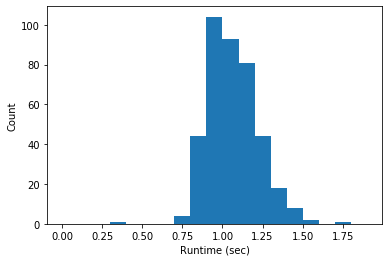

In [11]:
showRuntimeStats(runtimes)

In [168]:
search_percents = [search_time / runtime for (search_time, runtime) in zip(search_times, runtimes)]

In [169]:
sum(search_percents) / len(search_percents)

0.08840909104174394

In [170]:
sum(runtimes) / len(runtimes)

1.2552000552415847

In [157]:
sum(search_times) / len(search_times)

0.11398093283176422

In [172]:
bootleg_percents = [bootleg_time / runtime for (bootleg_time, runtime) in zip(bootleg_times, runtimes)]

In [173]:
sum(bootleg_percents) / len(bootleg_percents)

0.9115909089582565

In [158]:
sum(bootleg_times) / len(bootleg_times)

1.1412191224098205

In [159]:
sum(histogram_times) / len(histogram_times)

0.04642720401287079

In [160]:
sum(rank_times) / len(rank_times)

0.06755372881889343

#### Analysis 2: distribution of total runtime for training queries

Text(0.5, 0, 'Total runtime (s)')

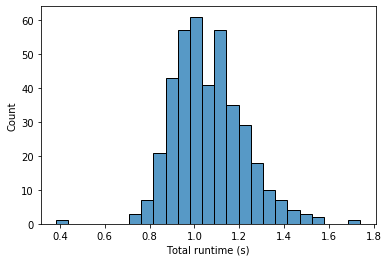

In [12]:
sns.histplot(runtimes)
plt.xlabel("Total runtime (s)")

Text(0.5, 0, 'Search runtime (s)')

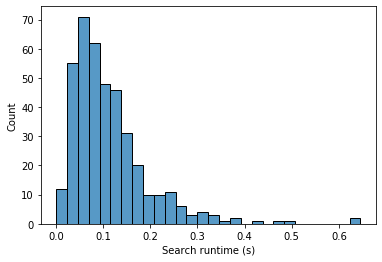

In [165]:
sns.histplot(search_times)
plt.xlabel("Search runtime (s)")

#### Analysis 3: query runtimes

In [15]:
from scipy import stats

In [20]:
num_features = []
search_times = []
num_matches = []

In [21]:
for query_id in query_search_times:
    num_features.append(num_features_per_query[query_id])
    search_times.append(query_search_times[query_id])
    num_matches.append(num_matches_per_query[query_id])

In [9]:
features_df = pd.DataFrame({
    'num_features': num_features,
    'search_times': search_times
})

In [16]:
slope, intercept, r_value, p_value, std_err = stats.linregress(features_df['num_features'],features_df['search_times'])

[Text(0, 0.5, 'Search runtime (s)'),
 Text(0.5, 0, 'Number of bootleg features')]

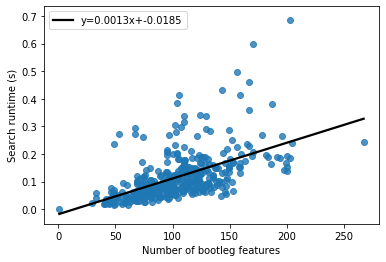

In [28]:
ax = sns.regplot(data = features_df, x = "num_features", y = "search_times", line_kws={'color': 'black', 'label':"y={0:.4f}x+{1:.4f}".format(slope,intercept)}, ci = None)
ax.legend()
ax.set(xlabel='Number of bootleg features', ylabel='Search runtime (s)')

##### Investigate outliers

In [111]:
for query in query_search_times:
    if query_search_times[query] > 0.4:
        print(query, query_search_times[query])

p15_q6 0.5992891788482666
p15_q8 0.45961809158325195
p15_q9 0.4967942237854004
p41_q9 0.412858247756958
p131_q6 0.41548871994018555
p145_q8 0.43302392959594727
p155_q4 0.6840529441833496


In [154]:
imagefile = 'data/queries/p15_q1.jpg'
pim1 = openImage(imagefile)

Processing data/queries/p15_q1.jpg


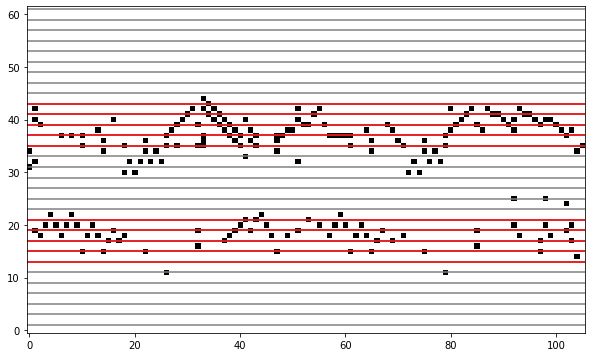

In [156]:
bscore_query=processQuery(imagefile)
visualizeLongBootlegScore(bscore_query, [13,15,17,19,21,35,37,39,41,43])

In [94]:
%load_ext line_profiler

In [157]:
temp_counts = []
%lprun -f getOffsetDeltaDynamicStaticN_GRAM processSingleQuery(imagefile, rindex_filter, counts=counts, mode="Dynamic_Static")

Processing data/queries/p15_q1.jpg
1.6773386001586914


In [11]:
matches_df = pd.DataFrame({
    'num_matches': num_matches,
    'search_times': search_times
})

[Text(0, 0.5, 'Search runtime (s)'),
 Text(0.5, 0, 'Total fingerprint matches processed (100,000,000)')]

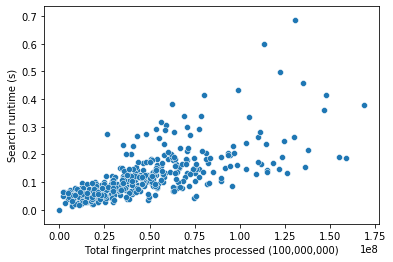

In [31]:
ax = sns.scatterplot(data = matches_df, x = "num_matches", y = "search_times", ci = None)
ax.set(xlabel='Total fingerprint matches processed (100,000,000)', ylabel='Search runtime (s)')

#### Analysis 4: n-gram lookups

In [32]:
import itertools
from collections import Counter

In [33]:
n_gram_lookups = list(itertools.chain.from_iterable(n_gram_dict.values()))

In [35]:
counts = Counter(n_gram_lookups)

In [40]:
counts

Counter({2: 18726, 4: 4312, 3: 8343, 1: 6025})

In [37]:
total = len(n_gram_lookups)

In [38]:
percentages = {k: (counts[k] / total) * 100 for k in counts}

In [39]:
percentages

{2: 50.061487461904505,
 4: 11.527562423140672,
 3: 22.3039084638828,
 1: 16.10704165107202}

#### Analysis 5: n-gram lookup transitions

In [41]:
transition_matrix = [[0 for _ in range(4)] for _ in range(4)]

In [42]:
for i in range(total - 1):
    a = n_gram_lookups[i]
    b = n_gram_lookups[i+1]
    transition_matrix[a-1][b-1] += 1

In [43]:
transition_matrix

[[2059, 2880, 761, 325],
 [3829, 12021, 2171, 704],
 [120, 3756, 3586, 881],
 [17, 68, 1825, 2402]]

In [44]:
row_sums = [sum(row) for row in transition_matrix]

In [45]:
new_matrix = [[round(e / row_sums[i] * 100, 2) for e in transition_matrix[i]] for i in range(4)]

In [46]:
new_matrix

[[34.17, 47.8, 12.63, 5.39],
 [20.45, 64.2, 11.59, 3.76],
 [1.44, 45.02, 42.98, 10.56],
 [0.39, 1.58, 42.32, 55.71]]

#### Analysis 7: scatterplot of lookups

In [28]:
with open('match_counts.pkl', 'rb') as f:
    matches = pickle.load(f)

In [29]:
matches_df = pd.DataFrame.from_dict(matches)

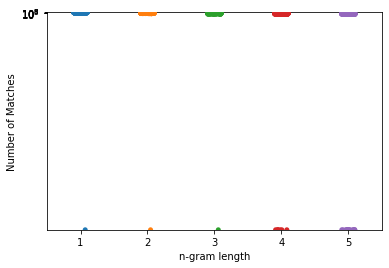

In [30]:
ax = sns.stripplot(data=matches_df)
ax.set(xlabel='n-gram length', ylabel='Number of Matches')
ax.set_ylim(0, 10**9)
ax.set_yscale('log')

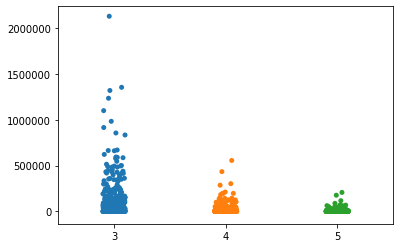

In [120]:
ax = sns.stripplot(data=matches_df.drop([1, 2], axis = 1))

In [52]:
data = [dynamic_matches[i] for i in range(1, 5)]

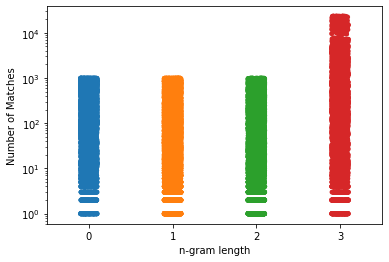

In [76]:
ax = sns.stripplot(data=data)
ax.set(xlabel='n-gram length', ylabel='Number of Matches')
ax.set_yscale('log')

#### Analysis 8: histogram of bootleg score lengths

In [22]:
num_features

[131,
 149,
 103,
 94,
 146,
 131,
 96,
 143,
 97,
 124,
 112,
 74,
 105,
 84,
 115,
 111,
 118,
 113,
 107,
 46,
 98,
 150,
 113,
 97,
 182,
 147,
 96,
 129,
 149,
 131,
 111,
 167,
 183,
 102,
 170,
 170,
 107,
 167,
 156,
 104,
 90,
 94,
 102,
 116,
 95,
 106,
 110,
 98,
 89,
 60,
 101,
 203,
 153,
 149,
 103,
 90,
 191,
 149,
 124,
 79,
 54,
 84,
 97,
 94,
 33,
 81,
 87,
 56,
 74,
 77,
 73,
 104,
 126,
 109,
 74,
 80,
 121,
 125,
 123,
 81,
 69,
 104,
 107,
 103,
 69,
 76,
 109,
 102,
 106,
 110,
 42,
 63,
 62,
 47,
 77,
 67,
 63,
 45,
 47,
 33,
 49,
 75,
 82,
 71,
 56,
 60,
 95,
 101,
 102,
 30,
 49,
 108,
 109,
 71,
 41,
 89,
 111,
 118,
 109,
 40,
 101,
 106,
 130,
 94,
 97,
 102,
 97,
 99,
 96,
 89,
 138,
 139,
 142,
 153,
 147,
 73,
 127,
 131,
 133,
 146,
 86,
 105,
 76,
 117,
 108,
 89,
 104,
 78,
 122,
 105,
 89,
 109,
 75,
 76,
 85,
 121,
 119,
 59,
 73,
 83,
 100,
 71,
 128,
 120,
 94,
 80,
 99,
 107,
 81,
 76,
 123,
 95,
 71,
 107,
 100,
 102,
 120,
 128,
 84,
 87,
 143,

[Text(0.5, 0, 'Number of bootleg features')]

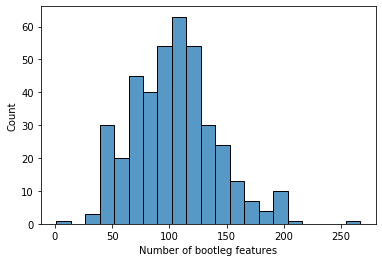

In [24]:
ax = sns.histplot(num_features)
ax.set(xlabel='Number of bootleg features')

In [25]:
avg_len = np.mean(num_features)
min_len = np.min(num_features)
max_len = np.max(num_features)
std_len = np.std(num_features)

In [35]:
print(f"average length: {round(avg_len, 2)}")
print(f"min length: {min_len}")
print(f"max length: {max_len}")
print(f"std dev: {round(std_len, 2)}")

average length: 104.36
min length: 1
max length: 267
std dev: 36.86


#### Analysis 9: histogram of number of noteheads in a single column

In [174]:
def bin_array(num, m):
    """Convert a positive integer num into an m-bit bit vector"""
    return np.array(list(np.binary_repr(num).zfill(m))).astype(np.int8)

In [278]:
notehead_counts = defaultdict(int)
staffline_counts = [0 for _ in range(62)]

In [279]:
d = counts[0]
for tup in d:
    num = tup[0]
    count = d[tup]
    bit_array = bin_array(num, 62)
    num_noteheads = np.count_nonzero(bit_array)
    for i in np.nonzero(bit_array)[0]:
        staffline_counts[i] += 1
    notehead_counts[num_noteheads] += count

In [280]:
notehead_counts

defaultdict(int,
            {4: 4649523,
             1: 27093780,
             2: 15533168,
             3: 7396935,
             5: 1774151,
             7: 208884,
             8: 100602,
             6: 761316,
             9: 18109,
             10: 5667,
             12: 910,
             11: 2008,
             13: 542,
             17: 199,
             14: 366,
             16: 214,
             20: 78,
             15: 244,
             18: 146,
             21: 39,
             25: 6,
             26: 7,
             24: 15,
             23: 24,
             22: 23,
             19: 112,
             27: 3})

Text(0, 0.5, 'Count')

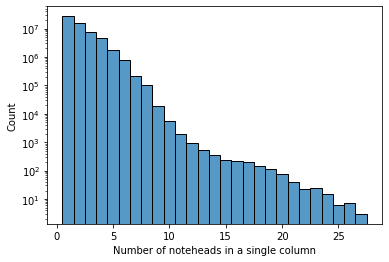

In [294]:
keys = list(notehead_counts.keys())
values = list(notehead_counts.values())
ax = sns.histplot(x=keys, weights=values, discrete=True)
ax.set_yscale("log")
ax.set_xlabel("Number of noteheads in a single column")
ax.set_ylabel("Count")

In [283]:
with open("notehead_counts.pkl", 'wb') as f:
    pickle.dump(notehead_counts, f)

#### Analysis 10: number of noteheads at each staff position

In [285]:
staffline_counts = {i: staffline_counts[i] for i in range(len(staffline_counts))}

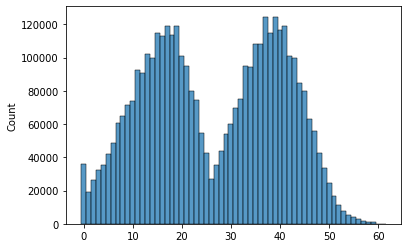

In [289]:
keys = list(staffline_counts.keys())
values = list(staffline_counts.values())
sns.histplot(x=keys, weights=values, discrete=True)

In [287]:
with open("staffline_counts.pkl", 'wb') as f:
    pickle.dump(staffline_counts, f)

#### Analysis 11

In [75]:
correct_fp_ratios

{'p1_q1': 0.8549618320610687,
 'p1_q2': 0.6301369863013698,
 'p1_q3': 0.696078431372549,
 'p1_q4': 0.8645833333333334,
 'p1_q5': 1.0342465753424657,
 'p1_q6': 0.6691729323308271,
 'p1_q7': 0.845360824742268,
 'p1_q8': 0.7552447552447552,
 'p1_q9': 0.8762886597938144,
 'p1_q10': 0.368,
 'p5_q1': 0.7232142857142857,
 'p5_q2': 0.581081081081081,
 'p5_q3': 0.40540540540540543,
 'p5_q4': 0.42168674698795183,
 'p5_q5': 0.6363636363636364,
 'p5_q6': 0.45535714285714285,
 'p5_q7': 0.8596491228070176,
 'p5_q8': 0.9107142857142857,
 'p5_q9': 0.2803738317757009,
 'p11_q1': 0.10784313725490197,
 'p11_q2': 0.22602739726027396,
 'p11_q3': 0.5726495726495726,
 'p11_q4': 0.25,
 'p11_q5': 0.6850828729281768,
 'p11_q6': 0.6095890410958904,
 'p11_q7': 0.18627450980392157,
 'p11_q8': 0.3816793893129771,
 'p11_q9': 0.32666666666666666,
 'p11_q10': 0.32558139534883723,
 'p15_q1': 0.5377358490566038,
 'p15_q2': 0.49696969696969695,
 'p15_q3': 0.5081967213114754,
 'p15_q4': 0.13861386138613863,
 'p15_q5': 0.7

In [83]:
for q in correct_fp_ratios:
    if correct_fp_ratios[q] > 1:
        print(q)

p1_q5
p35_q8
p35_q9
p51_q1
p51_q2
p51_q6
p51_q7
p61_q4
p61_q6
p61_q9
p61_q10
p81_q10
p121_q1
p121_q2
p121_q8
p121_q9
p121_q10
p135_q8
p135_q10
p151_q5
p151_q7


In [76]:
with open('fp_ratios.pkl', 'wb') as f:
    pickle.dump(correct_fp_ratios, f)

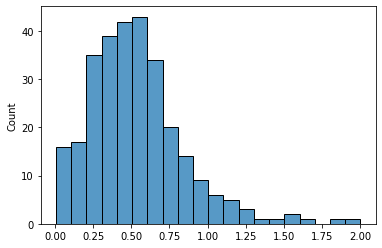

In [77]:
sns.histplot(data = list(correct_fp_ratios.values()))

In [78]:
nums = list(correct_fp_ratios.values())

In [79]:
np.mean(nums)

0.5309439400541479

In [80]:
np.min(nums)

0.007194244604316547

In [81]:
np.max(nums)

2.0

In [82]:
np.std(nums)

0.3113955651155662